# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec



import sys
sys.path.append('../functions/')
import trend_functions_2 as tf2

import load_dataset as load
from importlib import reload
import phase_calc_functions as phase_calc

import phase_plot_functions as phase_plot

In [2]:
# Loading awap
awap = load.load_awap()

# Loading RMM
rmm = load.load_rmm()

# Making sure the two are the same length
awap = awap.where(awap.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(awap.time.values), drop = True)
len(awap.time.values), len(rmm.time.values)

(7876, 7876)

# Wet-Season Calibration

In [3]:
# Readjusting the years, so when a resample takes plact, it is just the data for one wet season. If 
# this was not done it would be the end half of one wet season and the start of another. This moves that data
# from the start of the wet season back or forwards a year (I don't remember), so that they line up

phase_calc = reload(phase_calc)
awap_ws = phase_calc.wet_season_year(awap)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [4]:
import subphase_calc_functions as subphase_calc

In [5]:
awap_split_sub = subphase_calc.split_into_subphase(awap_ws, rmm)

In [6]:
awap_split_sub

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, time: 7617)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2017-12-31
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

In [7]:
enhanced_data  = awap_split_sub.sel(phase = 'enhanced')
suppressed_data  = awap_split_sub.sel(phase = 'suppressed')
inactive_data =awap_split_sub.sel(phase = 'inactive')

In [8]:
enhanced_data

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, time: 7617)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2017-12-31
    phase    <U8 'enhanced'
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

# Resample and Matching

<b> Counting the resmaples for awap data </b>

In [9]:
def count_resample(awap_data):
    # countring the rainfall events in each Wheeler and Hendon Phase
    awap_count = awap_data.resample(time = 'y').count(dim = 'time')
    awap_count['time'] = awap_count.time.dt.year
    awap_count = awap_count.rename({'time':'year', 'precip':'number'}) # to match the rmm count
    return awap_count

In [10]:
def sum_resample(awap_data):
    # sumring the rainfall events in each Wheeler and Hendon Phase
    awap_sum = awap_data.resample(time = 'y').sum(dim = 'time')
    awap_sum['time'] = awap_sum.time.dt.year
    awap_sum = awap_sum.rename({'time':'year', 'precip':'number'}) # to match the rmm sum
    return awap_sum

In [11]:
awap_count = count_resample(awap_ws)

awap_sum = sum_resample(awap_ws)

In [12]:
enhanced_data

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, time: 7617)
Coordinates:
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2017-12-31
    phase    <U8 'enhanced'
Data variables:
    precip   (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

In [13]:
enhanced_count = count_resample(enhanced_data)

enhanced_sum = sum_resample(enhanced_data)

In [14]:
inactive_count = count_resample(inactive_data)

inactive_sum = sum_resample(inactive_data)

In [15]:
suppressed_count = count_resample(suppressed_data)

suppressed_sum = sum_resample(suppressed_data)

In [16]:
enhanced_sum

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
    phase    <U8 'enhanced'
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
Data variables:
    number   (year, lat, lon) float32 0.0 87.826294 67.455894 ... 0.0 0.0 0.0

In [17]:
p50 = awap_ws.reduce(np.nanpercentile, q = 50, dim = 'time')
awap_50  = awap_ws.where(awap_ws.precip >= p50.precip)

awap_count_50 = count_resample(awap_50)

awap_sum_50 = sum_resample(awap_50)

In [18]:
p90 = awap_ws.reduce(np.nanpercentile, q = 90, dim = 'time')
awap_90  = awap_ws.where(awap_ws.precip >= p90.precip)

awap_count_90 = count_resample(awap_90)

awap_sum_90 = sum_resample(awap_90)

In [19]:
p95 = awap_ws.reduce(np.nanpercentile, q = 95, dim = 'time')
awap_95  = awap_ws.where(awap_ws.precip >= p95.precip)

awap_count_95 = count_resample(awap_95)

awap_sum_95 = sum_resample(awap_95)

<b> Resampling the RMM data </b>

In [20]:
# Countring the days in each Wheeler and Hendon Phase
tf2 = reload(tf2)
rmm_count = tf2.count_in_rmm_phase(rmm_ws)

rmm_count

rmm_count_sub = tf2.resample_phase_to_subphase(rmm_count)
rmm_count_sub = rmm_count_sub.isel(year = slice(0,43))

In [21]:
# Only correlation the enhanced phase, as this is the only phase with a positive trend
enhanced_count = rmm_count_sub.sel(phase = 'enhanced')

# Expanding the dims so that it can be correlated with every grid cell
enhanced_count = enhanced_count.expand_dims({'lat':awap_count.lat.values, 'lon':awap_count.lon.values})

enhanced_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 43)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
    phase    <U8 'enhanced'
Data variables:
    number   (lat, lon, year) float64 44.0 36.0 47.0 26.0 ... 45.0 72.0 35.0

<b> Matching the data so only the same years have been used in both </b>

In [22]:
def match_data(d1, d2):
    d1 = d1.where(d1.year.isin(d2.year.values), drop = True)
    d2 = d2.where(d2.year.isin(d1.year.values), drop = True)
    return d1, d2

In [23]:
awap_sum , enhanced_count = match_data(awap_sum , enhanced_count )

awap_count , enhanced_count = match_data(awap_count , enhanced_count )

In [24]:
awap_sum_50 , enhanced_count = match_data(awap_sum_50 , enhanced_count )

awap_count_50 , enhanced_count = match_data(awap_count_50 , enhanced_count )

In [25]:
awap_sum_90 , enhanced_count = match_data(awap_sum_90 , enhanced_count )

awap_count_90 , enhanced_count = match_data(awap_count_90 , enhanced_count )

In [26]:
awap_sum_95 , enhanced_count = match_data(awap_sum_95 , enhanced_count )

awap_count_95 , enhanced_count = match_data(awap_count_95 , enhanced_count )

# RMM Count

In [13]:
rmm

<xarray.Dataset>
Dimensions:    (time: 7876)
Coordinates:
  * time       (time) datetime64[ns] 1974-10-01 1974-10-02 ... 2017-12-31
Data variables:
    RMM1       (time) float64 0.5789 0.7589 0.8966 ... -1.191 -1.129 -1.063
    RMM2       (time) float64 -0.9097 -0.9504 -0.5804 ... -0.7119 -1.262 -1.591
    phase      (time) float64 3.0 3.0 4.0 4.0 4.0 5.0 ... 8.0 1.0 1.0 2.0 2.0
    amplitude  (time) float64 1.078 1.216 1.068 0.7765 ... 1.388 1.693 1.913

In [19]:
rmm_count

NameError: name 'rmm_count' is not defined

In [14]:
phase_number = rmm.groupby('phase').resample(time = 'y').sum()
e1 = phase_number.isel(time =slice(0,22)).sel(phase = [5,6,7])


AttributeError: 'DatasetGroupBy' object has no attribute 'resample'

# Linear Regress

## Calc

In [27]:
from scipy.stats import linregress

In [28]:
def helper(x, len_a):
    # split x into 'a' and 'b' parts
    
    xa = x[0:len_a] # awap values (y)
    xb = x[len_a:] # rmm values (x)
    
    grad, inter, r, p, std = linregress(xb,xa)
    
    return grad, p

def linregress_rmm(awap, rmm):
    
    # THis is concating the two different datasets into the one xarry file. They will be split down the middle
    # later on
    len_a = awap.dims['year']
    index_concat = xr.concat([awap,rmm], dim = 'year')

    axis =  index_concat.number.get_axis_num('year')
    arr = index_concat.number
    grad_meta, sig_meta = np.apply_along_axis(helper, arr = arr, 
                                         axis = axis, len_a = len_a)

    grad_vals = xr.Dataset({'precip':(('lat','lon'), grad_meta)},{
        'lat':awap.lat.values,
        'lon':awap.lon.values
    })
    
    
    linregress_sig = xr.Dataset({'precip':(('lat','lon'), sig_meta)},{

        'lat':awap.lat.values,
        'lon':awap.lon.values
    })
    
    # Getting only the significant points
    linregress_sig = linregress_sig.where(linregress_sig.precip < 0.05)
    
    return grad_vals, linregress_sig

In [29]:
'''All Rainfall'''
sum_reg, sum_sig = linregress_rmm(awap_sum, enhanced_count)

count_reg, count_sig = linregress_rmm(awap_count, enhanced_count)

'''50th Percetnile'''
sum_reg_50, sum_sig_50 = linregress_rmm(awap_sum_50, enhanced_count)

count_reg_50, count_sig_50 = linregress_rmm(awap_count_50, enhanced_count)

'''90th Percetnile'''
sum_reg_90, sum_sig_90 = linregress_rmm(awap_sum_90, enhanced_count)

count_reg_90, count_sig_90 = linregress_rmm(awap_count_90, enhanced_count)

'''95th Percetnile'''
sum_reg_95, sum_sig_95 = linregress_rmm(awap_sum_95, enhanced_count)

count_reg_95, count_sig_95 = linregress_rmm(awap_count_95, enhanced_count)


## Plotting

In [30]:
def linearreg_trend_plots(corr_data, stip_data = '', titles = '', num_rows = 1, num_cols = 1,
                        vmax = 0.5, step = 0.1, sig_size = 2.5, add_white = 1, extender = 0,
                        square = 0, # This is if I just want to plot the region where I take the median
                        suptitle = '', colorbar_title = '', 
                        savedir = ''):
            

    import matplotlib.patches as patch
    import matplotlib.colors as mpc
    import miscellaneous as misc

    # The columns will be the index, and the rosw will be the percentile

    
    fig  = plt.figure(figsize = (10 * num_cols,5 * num_rows)) #20/3 is the height adjust factor b/w subphase and phase
    gs = gridspec.GridSpec(num_rows + 1,num_cols, hspace = 0.4, wspace = 0.2, height_ratios = [0.2] + num_rows * [1])
#     fig.suptitle(title, fontsize = 35, y = 0.97)


    '''~~~~~~~~~~~~~~~~~ Creating a custom colorbar'''   
    vmin = -vmax
#     corr_data = misc.remove_outside_point(corr_data, vmax, vmin)
    cmap = plt.cm.RdBu
    levels = np.arange(vmin, vmax + step, step)
    
    # For this plot, in order for the stippling to be seen, the dark colors at the end need to be clipped off
    # This is doen be extending the cmap further on either side, then clipping the ends off
     # This is the extra amount of discrete colors to make
        # List  of all the colors
    custom_cmap = plt.cm.get_cmap('RdBu', len(levels) + extender)(np.arange(len(levels) + extender)) 
    if extender: # Chopping of some colors that are to dark to see the stippling
        custom_cmap = custom_cmap[extender:-extender] # CLipping the ends of either side
    
    if add_white:
        upper_mid = np.ceil(len(custom_cmap)/2)
        lower_mid = np.floor(len(custom_cmap)/2)
        white = [1,1,1,1]


        custom_cmap[int(upper_mid)] = white
        custom_cmap[int(lower_mid)] = white
        custom_cmap[int(lower_mid) - 1] = white
    
    cmap = mpc.LinearSegmentedColormap.from_list("RdWtBu", custom_cmap,len(levels)) 
    # Joingi the colormap back together

    
    '''~~~~~~~~~~~~~~~~~ Plotting Values'''  
    row = 0
    column = 0
    for data, sub_sig,title in zip(corr_data, stip_data, titles):
        
        data = data.precip
        sub_sig = sub_sig.precip
        
        ax = fig.add_subplot(gs[row + 1, column], projection  = ccrs.PlateCarree())

        X,Y = np.meshgrid(data.lon, data.lat)
        plot = ax.contourf(X,Y, data, cmap = cmap, levels = levels)
    #     plot = data.plot(ax = ax, cmap = cmap, levels = levels, add_colorbar = False)
        ax.set_title(title, fontsize = 20, pad = 5)
        ax.set_extent([113.8,150, -23,-10])

        if square:
            # This patch marks the square where the raifnall trend occurs
            ax.add_patch(patch.Rectangle((113.8,-23),21.2,10.8, fill = False, linestyle = '--', linewidth = 1.5))
#             ax.set_extent([113.8,135, -23,-10])
        
        if type(stip_data) != str:
      
            X,Y = np.meshgrid(sub_sig.lon, sub_sig.lat)

            sig = sub_sig.where(~np.isfinite(sub_sig), 1)
            size = np.nan_to_num(sig.values, 0)
            size[::2] = 0
    #         size[::5] = 0
            size = np.transpose(size)
            size[::2] = 0
    #         size[::5] = 0
            size = np.transpose(size)
            ax.scatter(X,Y, s = size * sig_size, color = 'k', alpha = 1)
            


        row += 1
        
        if row == num_rows:
            row = 0
            column += 1

            

        ax.outline_patch.set_visible(False)#Removing the spines of the plot. Cartopy requires different method
        ax.coastlines(resolution = '50m')

    '''~~~~~ Colorbar'''
    axes = plt.subplot(gs[0,:num_cols])
    cbar = plt.colorbar(plot, cax=axes, orientation = 'horizontal')#,norm = norm)
    cbar.ax.set_title(colorbar_title, size = 15);
    
    ticks = levels
    cbar.set_ticks(ticks)
    tick_labels = levels
    cbar.ax.set_xticklabels(np.round(tick_labels,2), fontsize = 12, rotation = 45)

    if savedir != '':
        fig.savefig(savedir + suptitle + '.png', dpi = 600, bbox_inches = 'tight', pad = 0)

In [31]:
savedir = '../images_2/trends/'

In [32]:
reg_list_sum = [sum_reg, sum_reg_50, sum_reg_90, sum_reg_95]
sig_list_sum = [sum_sig, sum_sig_50, sum_sig_90, sum_sig_95]

reg_list_count1 = [count_reg, count_reg_50]
reg_list_count2 = [count_reg_90, count_reg_95]
reg_list_count = [count_reg, count_reg_50,count_reg_90, count_reg_95]

sig_list_count1 = [count_sig, count_sig_50]
sig_list_count2 = [count_sig_90, count_sig_95]
sig_list_count = [count_sig, count_sig_50,count_sig_90, count_sig_95]



titles_sum = ['Total Rainfall','Total Rainfall > 50th Percentile','Total Rainfall > 90th Percentile',
          'Total Rainfall > 95th Percentile']
titles_count1 = ['Number of Raindays','Number of Raindays > 50th Percentile']
titles_count2 = ['Number of Raindays > 90th Percentile',
         'Number of Raindays > 95th Percentile']


titles_count = ['Number of Raindays','Number of Raindays > 50th Percentile','Number of Raindays > 90th Percentile',
         'Number of Raindays > 95th Percentile']

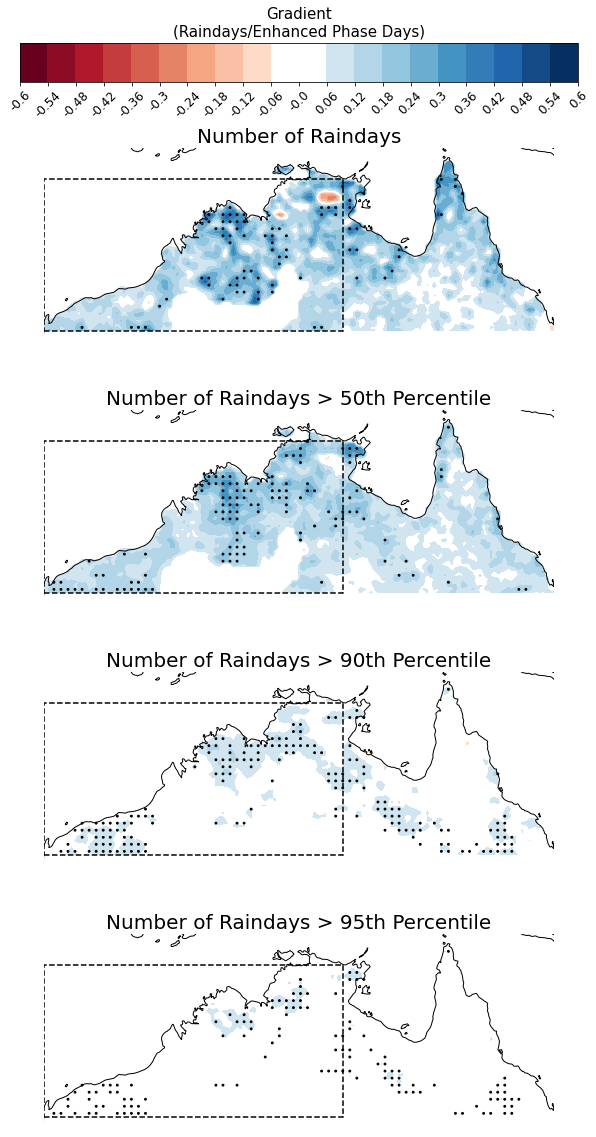

In [37]:
linearreg_trend_plots(corr_data = reg_list_count, stip_data = sig_list_count, titles = titles_count, sig_size = 3.5, 
                 num_rows = 4, num_cols = 1, vmax = 0.6, step = 0.6/10,
                 colorbar_title = 'Gradient\n(Raindays/Enhanced Phase Days)', 
                      suptitle = 'Linear_reg_number', square = 1
#                      )
                ,savedir = savedir)

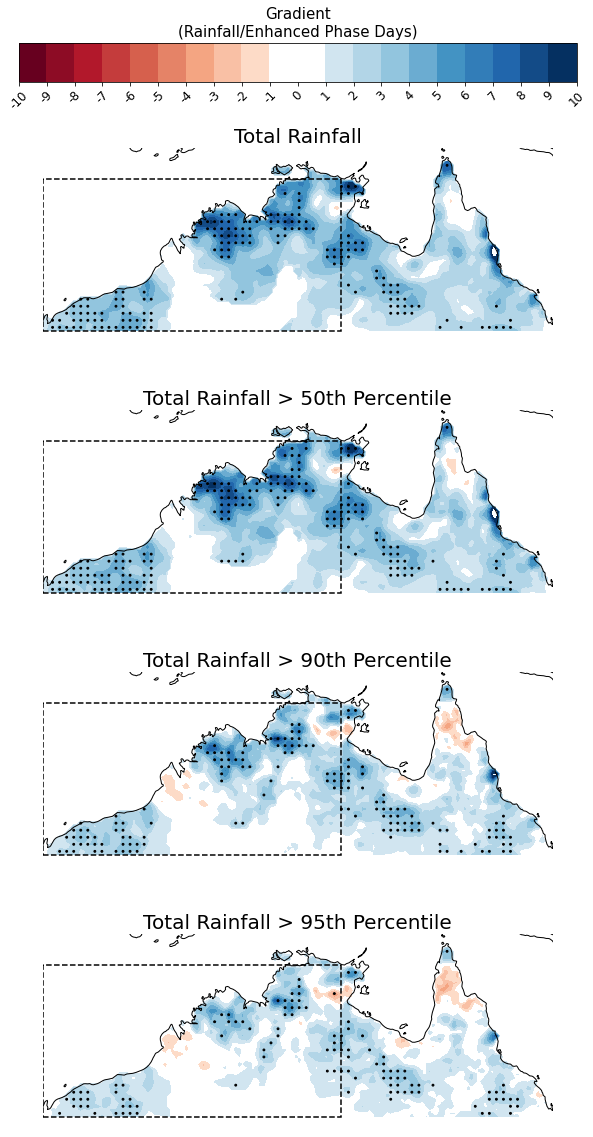

In [39]:
linearreg_trend_plots(corr_data = reg_list_sum, stip_data = sig_list_sum, titles = titles_sum, sig_size = 3.5, 
                 num_rows = 4, num_cols = 1, vmax = 10, step = 1,
                 colorbar_title = 'Gradient\n(Rainfall/Enhanced Phase Days)', suptitle = 'Linear_reg_total_rainfall', square = 1
#                      )
                ,savedir = savedir)

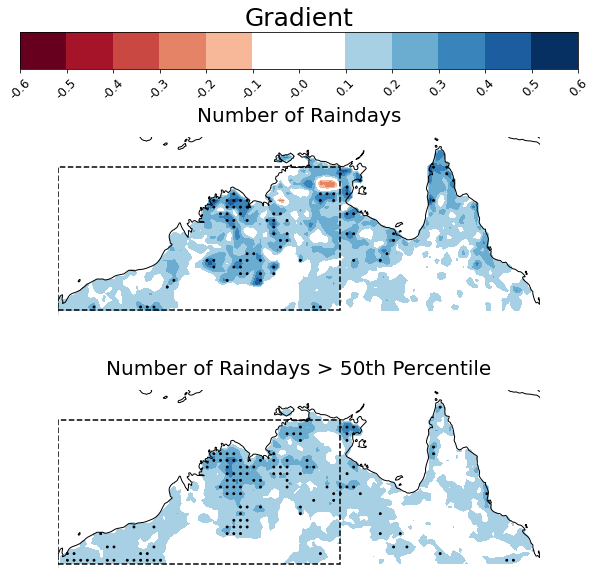

In [221]:
linearreg_trend_plots(corr_data = reg_list_count1, stip_data = sig_list_count1, titles = titles_count1, sig_size = 3.5, 
                 num_rows = 2, num_cols = 1, vmax = 0.6, step = 0.1,
                 colorbar_title = 'Gradient', title = 'regelation_squre', square = 1)
#                 ,savedir = savedir)

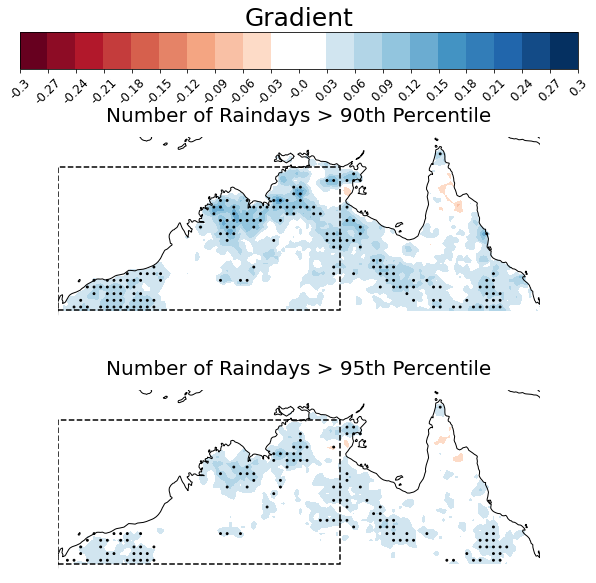

In [222]:
linearreg_trend_plots(corr_data = reg_list_count2, stip_data = sig_list_count2, titles = titles_count2, sig_size = 3.5, 
                 num_rows = 2, num_cols = 1, vmax = .3, step = 0.03,
                 colorbar_title = 'Gradient', title = 'regelation_squre', square = 1)
#                 ,savedir = savedir)

# Correlation

## Calculation

<b> Calculating the spearman rank correlation </b>

In [619]:
tf2 = reload(tf2)
sum_corr, sum_sig = tf2.spearman_correlation_rmm(awap_sum, enhanced_count)

count_corr, count_sig = tf2.spearman_correlation_rmm(awap_count, enhanced_count)

In [620]:
tf2 = reload(tf2)
sum_corr_50, sum_sig_50 = tf2.spearman_correlation_rmm(awap_sum_50, enhanced_count)

count_corr_50, count_sig_50 = tf2.spearman_correlation_rmm(awap_count_50, enhanced_count)

In [621]:
tf2 = reload(tf2)
sum_corr_90, sum_sig_90 = tf2.spearman_correlation_rmm(awap_sum_90, enhanced_count)

count_corr_90, count_sig_90 = tf2.spearman_correlation_rmm(awap_count_90, enhanced_count)

In [622]:
tf2 = reload(tf2)
sum_corr_95, sum_sig_95 = tf2.spearman_correlation_rmm(awap_sum_95, enhanced_count)

count_corr_95, count_sig_95 = tf2.spearman_correlation_rmm(awap_count_95, enhanced_count)

In [623]:
corr_list = [sum_corr, sum_corr_50, sum_corr_90, sum_corr_95,
             count_corr, count_corr_50, count_corr_90, count_corr_90]

In [624]:
sig_list = [sum_sig, sum_sig_50, sum_sig_90, sum_sig_95,
             count_sig, count_sig_50, count_sig_90, count_sig_90]

In [625]:
titles = ['Total Rainfall','Total Rainfall > 50th Percentile','Total Rainfall > 90th Percentile',
          'Total Rainfall > 95th Percentile',
          'Number of Raindays','Number of Raindays > 50th Percentile','Number of Raindays > 90th Percentile',
         'Number of Raindays > 95th Percentile']

## Ploting

In [626]:
def corr_trend_plots(corr_data, stip_data = '', titles = '', num_rows = 1, num_cols = 1,
                        vmax = 0.5, step = 0.1, sig_size = 2.5, add_white = 1, extender = 0,
                        square = 0, # This is if I just want to plot the region where I take the median
                        title = '', colorbar_title = '', 
                        savedir = ''):
            

    import matplotlib.colors as mpc

    # The columns will be the index, and the rosw will be the percentile

    
    fig  = plt.figure(figsize = (10 * num_cols,5 * num_rows)) #20/3 is the height adjust factor b/w subphase and phase
    gs = gridspec.GridSpec(num_rows + 1,num_cols, hspace = 0.5, wspace = 0.2, height_ratios = [0.2] + num_rows * [1])
    fig.suptitle(title, fontsize = 35, y = 0.97)


    '''~~~~~~~~~~~~~~~~~ Creating a custom colorbar'''   
    vmin = -vmax
    cmap = plt.cm.RdBu
    levels = np.arange(vmin, vmax + step, step)
    
    # For this plot, in order for the stippling to be seen, the dark colors at the end need to be clipped off
    # This is doen be extending the cmap further on either side, then clipping the ends off
     # This is the extra amount of discrete colors to make
        # List  of all the colors
    custom_cmap = plt.cm.get_cmap('RdBu', len(levels) + extender)(np.arange(len(levels) + extender)) 
    if extender: # Chopping of some colors that are to dark to see the stippling
        custom_cmap = custom_cmap[extender:-extender] # CLipping the ends of either side
    
    if add_white:
        upper_mid = np.ceil(len(custom_cmap)/2)
        lower_mid = np.floor(len(custom_cmap)/2)
        white = [1,1,1,1]


        custom_cmap[int(upper_mid)] = white
        custom_cmap[int(lower_mid)] = white
        custom_cmap[int(lower_mid) - 1] = white
    
    cmap = mpc.LinearSegmentedColormap.from_list("RdWtBu", custom_cmap,len(levels)) 
    # Joingi the colormap back together

    
    '''~~~~~~~~~~~~~~~~~ Plotting Values'''  
    row = 0
    column = 0
    for data, sub_sig,title in zip(corr_data, stip_data, titles):
        
        data = data.precip
        sub_sig = sub_sig.precip
        
        ax = fig.add_subplot(gs[row + 1, column], projection  = ccrs.PlateCarree())

        X,Y = np.meshgrid(data.lon, data.lat)
        plot = ax.contourf(X,Y, data, cmap = cmap, levels = levels)
    #     plot = data.plot(ax = ax, cmap = cmap, levels = levels, add_colorbar = False)
        ax.set_title(title, fontsize = 20, pad = 30)
        
        if square:
            ax.set_extent([113.8,135, -23,-10])
        
        if type(stip_data) != str:
      
            X,Y = np.meshgrid(sub_sig.lon, sub_sig.lat)

            sig = sub_sig.where(~np.isfinite(sub_sig), 1)
            size = np.nan_to_num(sig.values, 0)
            size[::2] = 0
    #         size[::5] = 0
            size = np.transpose(size)
            size[::2] = 0
    #         size[::5] = 0
            size = np.transpose(size)
            ax.scatter(X,Y, s = size * sig_size, color = 'k', alpha = 1)
            


        row += 1
        
        if row == num_rows:
            row = 0
            column += 1

            

        ax.outline_patch.set_visible(False)#Removing the spines of the plot. Cartopy requires different method
        ax.coastlines(resolution = '50m')

    '''~~~~~ Colorbar'''
    axes = plt.subplot(gs[0,:num_cols])
    cbar = plt.colorbar(plot, cax=axes, orientation = 'horizontal')#,norm = norm)
    cbar.ax.set_title(colorbar_title, size = 25);
    
    ticks = levels
    cbar.set_ticks(ticks)
    tick_labels = levels
    cbar.ax.set_xticklabels(np.round(tick_labels,1), fontsize = 15)

    if savedir != '':
        fig.savefig(savedir + title + '.png', dpi = 400)

In [627]:
savedir = 'correlation/'

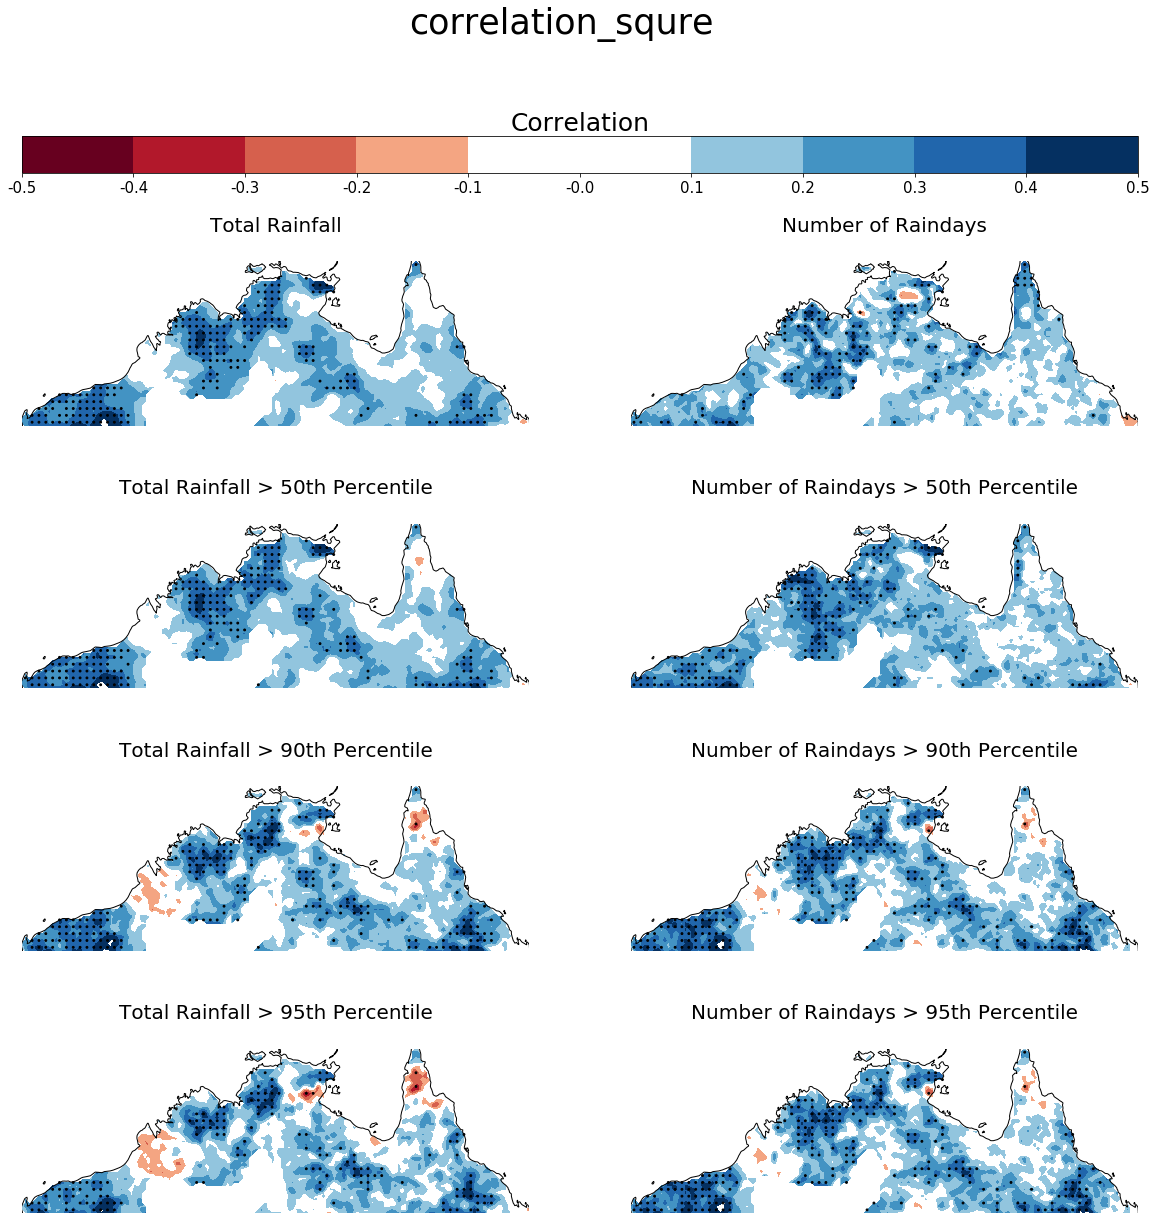

In [630]:
corr_trend_plots(corr_data = corr_list, stip_data = sig_list, titles = titles, sig_size = 3.5, 
                 num_rows = 4, num_cols = 2, 
                 colorbar_title = 'Correlation', title = 'correlation_squre', square = 0)
#                 ,savedir = savedir)

In [46]:
savedir = '../images_2/trends/'

# PDF's

In [234]:
savedir = 'trends/awap/med_trends/'

In [52]:
import miscellaneous as misc

In [82]:
awap_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    number   (year, lat, lon) float64 0.0 14.0 16.0 17.0 ... 0.0 0.0 0.0 0.0

In [84]:
awap_count_sub = misc.apply_masks(awap_count)
awap_count_sub = awap_count_sub.sel(lon = slice(110, 135), lat = slice(-25,-10))

awap_sum_sub = misc.apply_masks(awap_sum)
awap_sum_sub = awap_sum_sub.sel(lon = slice(110, 135), lat = slice(-25,-10))

In [71]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [92]:
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'

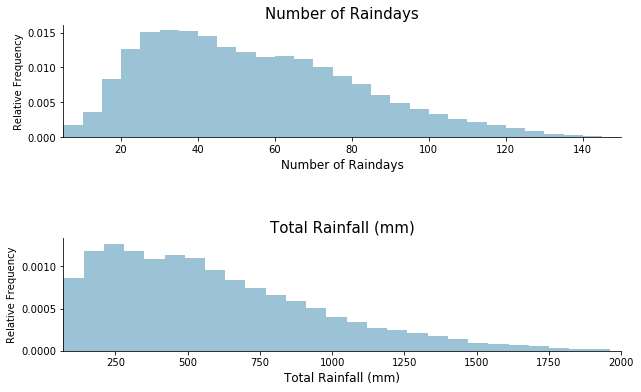

In [249]:
fig = plt.figure(figsize = (10,6))

gs = gridspec.GridSpec(2,1, hspace = 0.9)

ax1 = fig.add_subplot(gs[0])
ax1.hist(awap_count_sub.number.values.flatten(), bins = np.arange(5,150,5), density = True, color = best_blue);
remove_spines(ax1)
ax1.set_title('Number of Raindays', fontsize = 15);
ax1.set_ylabel('Relative Frequency', rotation = 90)
ax1.set_xlabel('Number of Raindays', fontsize =12)
ax1.set_xlim(5,150)

ax2 = fig.add_subplot(gs[1])
ax2.hist(awap_sum_sub.number.values.flatten(), bins = np.arange(70,2000,70), density = True, color = best_blue);
remove_spines(ax2)
ax2.set_title('Total Rainfall (mm)', fontsize = 15);
ax2.set_ylabel('Relative Frequency', rotation = 90)
ax2.set_xlabel('Total Rainfall (mm)', fontsize =12)
ax2.set_xlim(70,2000)
fig.savefig(savedir + 'pdf.png', dpi = 400)

In [480]:
count_sub_sub = awap_count_sub.isel(year = slice(0,21))
sum_sub_sub = awap_sum_sub.isel(year = slice(0,21))

count_sub_sub2 = awap_count_sub.isel(year = slice(22,43))
sum_sub_sub2 = awap_sum_sub.isel(year = slice(22,43))

In [481]:
from scipy.stats import ttest_ind

In [482]:
sum_sub_sub2

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 85, year: 21)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 114.0 114.2 114.5 114.8 ... 134.2 134.5 134.8 135.0
  * year     (year) int64 1997 1998 1999 2000 2001 ... 2013 2014 2015 2016 2017
Data variables:
    number   (year, lat, lon) float32 108.458496 153.7921 195.78484 ... nan nan

In [483]:
sum_sub_sub

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 85, year: 21)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 114.0 114.2 114.5 114.8 ... 134.2 134.5 134.8 135.0
  * year     (year) int64 1975 1976 1977 1978 1979 ... 1991 1992 1993 1994 1995
Data variables:
    number   (year, lat, lon) float32 235.36752 242.62985 236.79872 ... nan nan

In [484]:
from scipy.stats import kstest

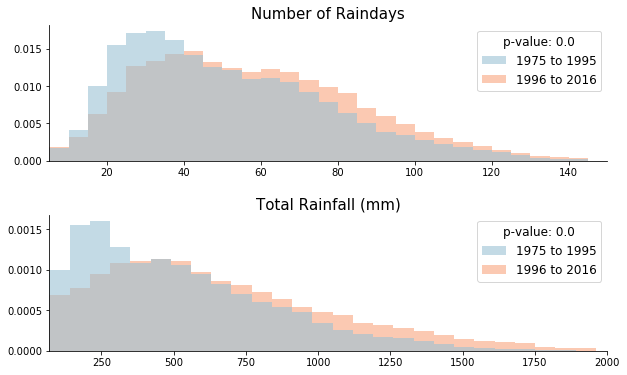

In [486]:
fig = plt.figure(figsize = (10,6))

gs = gridspec.GridSpec(2,1, hspace = 0.4)

ax1 = fig.add_subplot(gs[0])

count1 = count_sub_sub.number.values.flatten()
count2 = count_sub_sub2.number.values.flatten()

ax1.hist(count1, bins = np.arange(5,150,5), density = True, color = best_blue,
        alpha = 0.6, zorder = 1, label = '1975 to 1995');
ax1.hist(count2, bins = np.arange(5,150,5), density = True, 
         color = recherche_red,alpha = 0.9,zorder = 0, label = '1996 to 2016');
remove_spines(ax1)
ax1.set_xlim(5,150)

stat1,pval1 = ttest_ind(count1,count2, nan_policy = 'omit')
ax1.set_title('Number of Raindays', fontsize = 15);
leg = ax1.legend(fontsize = 12)
leg.set_title('p-value: ' + str(np.round(pval1,4)))
leg.get_title().set_fontsize(12)

# ax1.annotate('p-values: ' + str(np.round(pval1)), xy = (0.5, 0.8), xycoords = 'axes fraction', fontsize = 14)


ax2 = fig.add_subplot(gs[1])

sum1 = sum_sub_sub.number.values.flatten()
sum2 = sum_sub_sub2.number.values.flatten()
stat2,pval2 = ttest_ind(sum1,sum2, nan_policy = 'omit')
ax2.hist(sum1, bins = np.arange(70,2000,70), density = True, color = best_blue,
        alpha = 0.6, zorder = 1, label = '1975 to 1995');
ax2 = fig.add_subplot(gs[1])
ax2.hist(sum2, bins = np.arange(70,2000,70), density = True, color = recherche_red,
        alpha = 0.9, zorder = 0, label = '1996 to 2016');
remove_spines(ax2)
ax2.set_title('Total Rainfall (mm)', fontsize = 15);
ax2.set_xlim(70,2000)
leg = ax2.legend(fontsize = 12)
leg.set_title('p-value: ' + str(np.round(pval2,4)))
leg.get_title().set_fontsize(12)


fig.savefig(savedir + 'pdf_comparison.png', dpi = 400)

In [455]:
enhanced_sum

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
    phase    <U8 'enhanced'
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    number   (year, lat, lon) float32 0.0 87.826294 67.455894 ... 0.0 0.0 0.0

In [510]:
enhanced_count = misc.apply_masks(enhanced_count)
enhanced_count_sub = enhanced_count.sel(lon = slice(110, 135), lat = slice(-25,-10))

enhanced_sum = misc.apply_masks(enhanced_sum)
enhanced_sum_sub = enhanced_sum.sel(lon = slice(110, 135), lat = slice(-25,-10))

count_sub_sub = enhanced_count_sub.isel(year = slice(0,21))
sum_sub_sub = enhanced_sum_sub.isel(year = slice(0,21))

count_sub_sub2 = enhanced_count_sub.isel(year = slice(22,43))
sum_sub_sub2 = enhanced_sum_sub.isel(year = slice(22,43))

In [504]:
suppressed_count = misc.apply_masks(suppressed_count)
suppressed_count_sub = suppressed_count.sel(lon = slice(110, 135), lat = slice(-25,-10))

suppressed_sum = misc.apply_masks(suppressed_sum)
suppressed_sum_sub = suppressed_sum.sel(lon = slice(110, 135), lat = slice(-25,-10))

count_sub_sub = suppressed_count_sub.isel(year = slice(0,21))
sum_sub_sub = suppressed_sum_sub.isel(year = slice(0,21))

count_sub_sub2 = suppressed_count_sub.isel(year = slice(22,43))
sum_sub_sub2 = suppressed_sum_sub.isel(year = slice(22,43))

In [508]:
inactive_count = misc.apply_masks(inactive_count)
inactive_count_sub = inactive_count.sel(lon = slice(110, 135), lat = slice(-25,-10))

inactive_sum = misc.apply_masks(inactive_sum)
inactive_sum_sub = inactive_sum.sel(lon = slice(110, 135), lat = slice(-25,-10))

count_sub_sub = inactive_count_sub.isel(year = slice(0,21))
sum_sub_sub = inactive_sum_sub.isel(year = slice(0,21))

count_sub_sub2 = inactive_count_sub.isel(year = slice(22,43))
sum_sub_sub2 = inactive_sum_sub.isel(year = slice(22,43))

In [500]:
from scipy.stats import ks_2samp

1.1993351756706174e-237 1.7760543068424433e-197


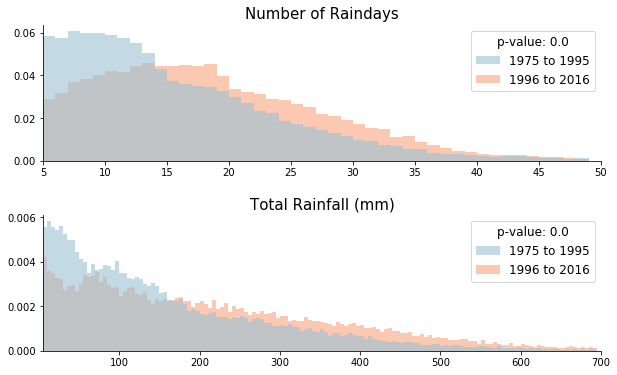

In [511]:
fig = plt.figure(figsize = (10,6))

gs = gridspec.GridSpec(2,1, hspace = 0.4)

ax1 = fig.add_subplot(gs[0])

count1 = count_sub_sub.number.values.flatten()
count2 = count_sub_sub2.number.values.flatten()

ax1.hist(count1, bins = np.arange(5,50,1), density = True, color = best_blue,
        alpha = 0.6, zorder = 1, label = '1975 to 1995');
ax1.hist(count2, bins = np.arange(5,50,1), density = True, 
         color = recherche_red,alpha = 0.9,zorder = 0, label = '1996 to 2016');
remove_spines(ax1)

ax1.set_xlim(5,50)
stat1,pval1 = ks_2samp(count1, count2)
ax1.set_title('Number of Raindays', fontsize = 15);
leg = ax1.legend(fontsize = 12)
leg.set_title('p-value: ' + str(np.round(pval1,4)))
leg.get_title().set_fontsize(12)

# ax1.annotate('p-values: ' + str(np.round(pval1)), xy = (0.5, 0.8), xycoords = 'axes fraction', fontsize = 14)


ax2 = fig.add_subplot(gs[1])

sum1 = sum_sub_sub.number.values.flatten()
sum2 = sum_sub_sub2.number.values.flatten()


stat2,pval2 = ks_2samp(sum1, sum2)
ax2.hist(sum1, bins = np.arange(5,700,5), density = True, color = best_blue,
        alpha = 0.6, zorder = 1, label = '1975 to 1995');
ax2 = fig.add_subplot(gs[1])
ax2.hist(sum2, bins = np.arange(5,700,5), density = True, color = recherche_red,
        alpha = 0.9, zorder = 0, label = '1996 to 2016');
remove_spines(ax2)
ax2.set_title('Total Rainfall (mm)', fontsize = 15);
ax2.set_xlim(5,700)
leg = ax2.legend(fontsize = 12)
leg.set_title('p-value: ' + str(np.round(pval2,4)))
leg.get_title().set_fontsize(12)

print(pval1, pval2)
# fig.savefig(savedir + 'pdf_comparison_inactive.png', dpi = 400)

# Overall Trends

In [141]:
from scipy.stats import spearmanr
from scipy.stats import linregress

SpearmanrResult(correlation=0.4265897903656832, pvalue=0.023586653121187125)

In [120]:
sum_med = awap_sum_sub.median(dim = ['lat','lon'])
count_med = awap_count_sub.median(dim = ['lat','lon'])

In [520]:
rmm_count_sub

<xarray.Dataset>
Dimensions:  (phase: 4, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inacitve'
Data variables:
    number   (phase, year) float64 44.0 36.0 47.0 26.0 ... 86.0 56.0 46.0 89.0

In [524]:
enhanced_count = rmm_count_sub.sel(phase = 'enhanced')
enhanced_count

<xarray.Dataset>
Dimensions:  (year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
    phase    <U8 'enhanced'
Data variables:
    number   (year) float64 44.0 36.0 47.0 26.0 23.0 ... 40.0 45.0 72.0 35.0

Text(1.1,0.3,'$\\bf{1990\\:to\\:2017:}$\nCorrelation: 0.34 p-value: 0.08')

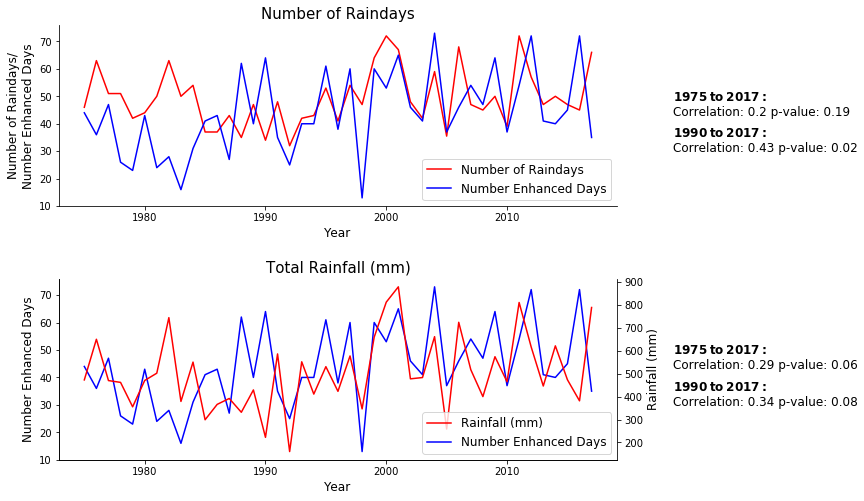

In [525]:
fig = plt.figure(figsize = (10,8))
gs = gridspec.GridSpec(2,1, hspace = 0.4)



ax = fig.add_subplot(gs[0])
count_med.number.plot(ax = ax, color = 'red',label = 'Number of Raindays')
enhanced_count.number.plot(ax = ax, color = 'blue', label = 'Number Enhanced Days')
remove_spines(ax)
ax.set_title('Number of Raindays', fontsize = 15)
ax.set_xlabel('Year', fontsize = 12)
ax.set_ylabel('Number of Raindays/\nNumber Enhanced Days', fontsize = 12)
leg = ax.legend(loc = 'best', fontsize = 12)

corr,pval = spearmanr(count_med.number.values.flatten(), enhanced_count.number.values.flatten(),\
                      nan_policy = 'omit')
corr2,pval2 = spearmanr(count_med.number.sel(year = slice(1990,2017)).values.flatten(), 
                        enhanced_count.number.sel(year = slice(1990,2017)).values.flatten(),\
                      nan_policy = 'omit')

ax.annotate(r"$\bf{1975\:to\:2017:}$" + f'\nCorrelation: {(np.round(corr, 2))} p-value: {np.round(pval,2)}',
          xy = (1.1,0.5), xycoords = 'axes fraction', fontsize = 12)

ax.annotate(r"$\bf{1990\:to\:2017:}$" + f'\nCorrelation: {(np.round(corr2, 2))} p-value: {np.round(pval2,2)}',
          xy = (1.1,0.3), xycoords = 'axes fraction', fontsize = 12)



ax = fig.add_subplot(gs[1])

ax2 = ax.twinx()
l2 = enhanced_count.number.plot(ax = ax, color = 'blue', label = 'Number Enhanced Days')
l1 = sum_med.number.plot(ax = ax2, color = 'red', label = 'Rainfall (mm)')
remove_spines(ax)
ax2.spines['top'].set_visible(False)
ax.set_title('Total Rainfall (mm)', fontsize = 15)
ax.set_xlabel('Year', fontsize = 12)

lns = l1 + l2
labs = [ 'Rainfall (mm)','Number Enhanced Days']
ax2.set_ylabel('Rainfall (mm)', fontsize = 12)
ax.set_ylabel('Number Enhanced Days', fontsize = 12)
ax2.legend(lns, labs, loc = 'lower right', fontsize = 12)



corr,pval = spearmanr(sum_med.number.values.flatten(), enhanced_count.number.values.flatten(),\
                      nan_policy = 'omit')
corr2,pval2 = spearmanr(sum_med.number.sel(year = slice(1990,2017)).values.flatten(), 
                        enhanced_count.number.sel(year = slice(1990,2017)).values.flatten(),\
                      nan_policy = 'omit')

ax.annotate(r"$\bf{1975\:to\:2017:}$" + f'\nCorrelation: {(np.round(corr, 2))} p-value: {np.round(pval,2)}',
          xy = (1.1,.5), xycoords = 'axes fraction', fontsize = 12)

ax.annotate(r"$\bf{1990\:to\:2017:}$" + f'\nCorrelation: {(np.round(corr2, 2))} p-value: {np.round(pval2,2)}',
          xy = (1.1,0.3), xycoords = 'axes fraction', fontsize = 12)


# fig.savefig(savedir + 'corr_plot_inactive.png', dpi = 400, bbox_inches = 'tight')

In [305]:
def regress_plot(ax, d1, d2):

    lr = linregress(d1,d2)
    x = np.linspace(np.min(d1), np.max(d1), 100)
    y  = lr[0] * x + lr[1]


    ax.scatter(d1,d2, color = 'red')
    ax.plot(x,y, color = 'black')


    r_val = np.round(lr[2],2)
    p_val = np.round(lr[3],2)
    slope = np.round(lr[0],2)
    ax.annotate(f'slope: {slope}\nr: {r_val}\np-value: {p_val}', xy = (0.04,0.75), xycoords = 'axes fraction'
               ,size = 15)
    
    remove_spines(ax)

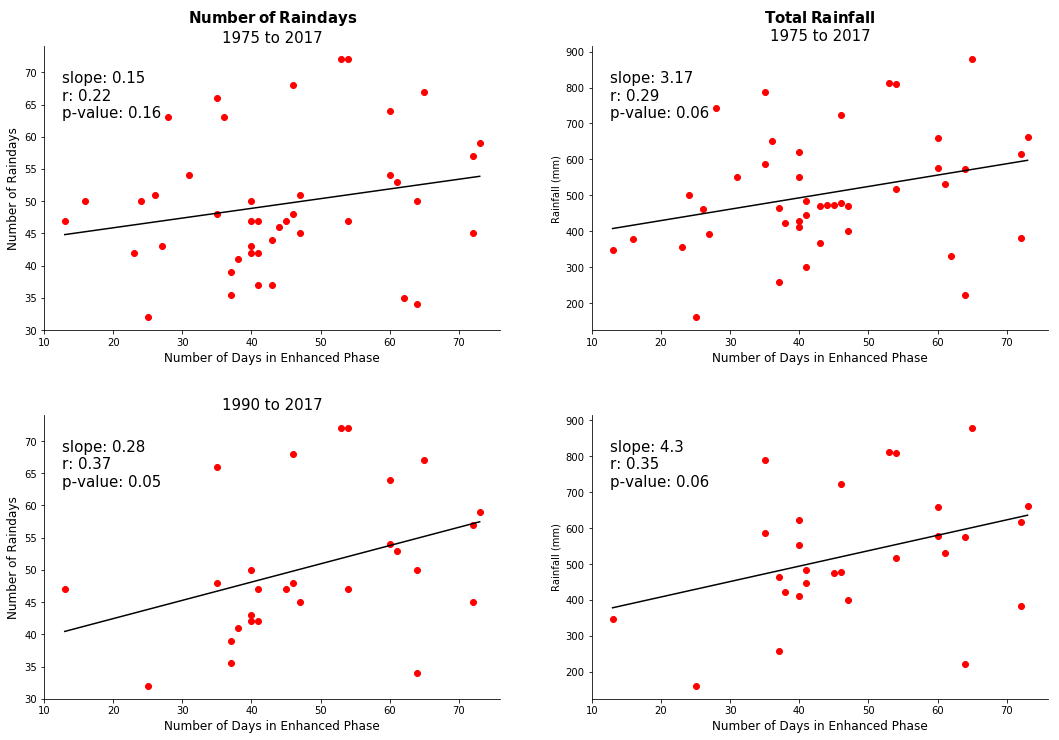

In [313]:

fig = plt.figure(figsize = (18,12))
gs = gridspec.GridSpec(2,2, hspace = 0.3)


d00 = enhanced_count.number
d01 =  count_med.number
d02 = sum_med.number



d10 = enhanced_count.sel(year = slice(1990, 2017)).number
d11 =  count_med.sel(year = slice(1990, 2017)).number
d12 =  sum_med.sel(year = slice(1990, 2017)).number



ax = fig.add_subplot(gs[0])
regress_plot(ax, d00,d01)

ax.set_title(r"$\bf{Number\: of \: Raindays}$" + '\n1975 to 2017', fontsize = 15)
ax.set_xlabel('Number of Days in Enhanced Phase', fontsize = 12)
ax.set_ylabel('Number of Raindays', fontsize =12)

ax = fig.add_subplot(gs[1])
regress_plot(ax, d00,d02)
ax.set_title(r"$\bf{Total \: Rainfall}$" + '\n1975 to 2017', fontsize = 15)
ax.set_xlabel('Number of Days in Enhanced Phase', fontsize = 12)
ax.set_ylabel('Rainfall (mm)')


ax = fig.add_subplot(gs[2])
regress_plot(ax, d10,d11)
ax.set_title('1990 to 2017', fontsize = 15)
ax.set_xlabel('Number of Days in Enhanced Phase', fontsize = 12)
ax.set_ylabel('Number of Raindays', fontsize =12)


ax = fig.add_subplot(gs[3])
regress_plot(ax, d10,d12)
ax.set_xlabel('Number of Days in Enhanced Phase', fontsize = 12)
ax.set_ylabel('Rainfall (mm)')
fig.savefig(savedir + 'regress_plot.png', dpi = 500)

## Grid Trend

### Calculation

In [28]:
import mystats as stats

In [29]:
awap_count

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    number   (year, lat, lon) float64 0.0 14.0 16.0 17.0 ... 0.0 0.0 0.0 0.0

In [30]:
awap_sum

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, year: 43)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2013 2014 2015 2016 2017
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
Data variables:
    number   (year, lat, lon) float32 0.0 235.36752 242.62985 ... 0.0 0.0 0.0

In [31]:
import mystats

# Calculates the trend for each individaul grid cell
def grid_trend(x,t):
    # If every point is just a nan values. We don't want to do the polyfit calculation. Just return nan
    if np.all(np.isnan(x)):
        return float('nan')
    
    # Getting the gradient of a linear interpolation
    idx = np.isfinite(x) & np.isfinite(t) #checking where the nans are for both
    grad = np.polyfit(t[idx],x[idx],1)[0]
    return grad


def calculate_trend(percentile):
    
  
    # The axis number that year is
    axis_num = percentile.get_axis_num('year')
    
    '''Applying trends along each grid cell'''
    percenilte_trend_meta = np.apply_along_axis(grid_trend,axis_num, percentile.values, 
                                                t = percentile.year.values)

    '''Turning into an xarray dataset'''
    trend  = xr.Dataset(
        {'trend':(('lat','lon'), percenilte_trend_meta)},

        {
         'lat':percentile.lat,
        'lon':percentile.lon}
    )
    
    
    
    return trend

def convert_to_percent_per_decade(percentile, trend):
    
    mean_gridcell = percentile.mean(dim = 'year')
    
    
    return (trend * 10 / mean_gridcell) * 100

def calculate_pvals(percentile, trend):
    year_num = percentile.get_axis_num('year')
    
    trend_pval_meta = np.apply_along_axis(mystats.mann_kendall, year_num, percentile)


    pvals  = xr.Dataset(
        {'pvals':(('lat','lon'), trend_pval_meta)},

        {
         'lat':percentile.lat,
        'lon':percentile.lon}
    )
    
    
    return pvals

def significant_trend_cacl(data, pvals):
    sig = data.where(np.logical_and(pvals.pvals >= 0 ,pvals.pvals <= 0.05  ))
    

    return sig



def overall_trend_info(data):
    import load_dataset as load

    print('calculating trend', end = '')
    # Calculates the trend
    trend = calculate_trend(data)
    print(': complete')
    
    
    # Convertes to percent per decade
    print('converting to percent per decade', end = '')
    trend_percent = convert_to_percent_per_decade(data, trend)
    print(': complete')
    
    # Calculates the significant values
    print('finding significant points', end = '')
    pvals =  calculate_pvals(data, trend)
    print(': complete')
    print('getting just significant trend points', end = '')
    trend_sig = significant_trend_cacl(trend, pvals)
    trend_percent_sig = significant_trend_cacl(trend_percent, pvals)
    print(': complete')
    trend = trend.rename({'trend':'precip'})
    trend_sig = trend_sig.rename({'trend':'precip'})
    trend_percent = trend_percent.rename({'trend':'precip'})
    trend_percent_sig = trend_percent_sig.rename({'trend':'precip'})
    
    return trend, trend_sig, trend_percent, trend_percent_sig



In [32]:
# The number of rainfall events
count_trend, count_trend_sig, count_trend_percent, count_trend_percent_sig = overall_trend_info(awap_count.number)

#50th percentile
count_50_trend, count_50_trend_sig, count_50_trend_percent, count_50_trend_percent_sig = \
       overall_trend_info(awap_count_50.number)
#90th percentile
count_90_trend, count_90_trend_sig, count_90_trend_percent, count_90_trend_percent_sig = \
       overall_trend_info(awap_count_90.number)
# 95th percentile
count_95_trend, count_95_trend_sig, count_95_trend_percent, count_95_trend_percent_sig = \
       overall_trend_info(awap_count_95.number)

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


In [33]:
# The number of rainfall events
sum_trend, sum_trend_sig, sum_trend_percent, sum_trend_percent_sig = overall_trend_info(awap_sum.number)

#50th percentile
sum_50_trend, sum_50_trend_sig, sum_50_trend_percent, sum_50_trend_percent_sig = \
       overall_trend_info(awap_sum_50.number)
#90th percentile
sum_90_trend, sum_90_trend_sig, sum_90_trend_percent, sum_90_trend_percent_sig = \
       overall_trend_info(awap_sum_90.number)
# 95th percentile
sum_95_trend, sum_95_trend_sig, sum_95_trend_percent, sum_95_trend_percent_sig = \
       overall_trend_info(awap_sum_95.number)

calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete
calculating trend: complete
converting to percent per decade: complete
finding significant points: complete
getting just significant trend points: complete


### Grid Maps

In [39]:

import matplotlib.patches as patch

In [40]:
def trend_plots(corr_data, stip_data = '', titles = '', num_rows = 1, num_cols = 1,
                        vmax = 0.5, step = 0.1, sig_size = 2.5, add_white = 1, extender = 0,
                        suptitle = '', colorbar_title = '', 
                        savedir = ''):
            

    import matplotlib.colors as mpc

    # The columns will be the index, and the rosw will be the percentile

    
    fig  = plt.figure(figsize = (10 * num_cols,5 * num_rows)) #20/3 is the height adjust factor b/w subphase and phase
    gs = gridspec.GridSpec(num_rows + 1,num_cols, hspace = 0.5, wspace = 0.2, height_ratios = [0.2] + num_rows * [1])
#     fig.suptitle(suptitle, fontsize = 35, y = 0.97)


    '''~~~~~~~~~~~~~~~~~ Creating a custom colorbar'''   
    vmin = -vmax
    cmap = plt.cm.RdBu
    levels = np.arange(vmin, vmax + step, step)
    
    # For this plot, in order for the stippling to be seen, the dark colors at the end need to be clipped off
    # This is doen be extending the cmap further on either side, then clipping the ends off
     # This is the extra amount of discrete colors to make
    custom_cmap = plt.cm.get_cmap('RdBu', len(levels) + extender)(np.arange(len(levels) + extender)) # List  of all the colors
    if extender: # Chopping of some colors that are to dark to see the stippling
        custom_cmap = custom_cmap[extender:-extender] # CLipping the ends of either side
    
    if add_white:
        upper_mid = np.ceil(len(custom_cmap)/2)
        lower_mid = np.floor(len(custom_cmap)/2)
        white = [1,1,1,1]


        custom_cmap[int(upper_mid)] = white
        custom_cmap[int(lower_mid)] = white
        custom_cmap[int(lower_mid) - 1] = white
    
    cmap = mpc.LinearSegmentedColormap.from_list("RdWtBu", custom_cmap,len(levels)) # Joingi the colormap back together

    
    '''~~~~~~~~~~~~~~~~~ Plotting Values'''  
    row = 0
    column = 0
    for data, sub_sig,title in zip(corr_data, stip_data, titles):
        
        data = data.precip
        sub_sig = sub_sig.precip
        
        ax = fig.add_subplot(gs[row + 1, column], projection  = ccrs.PlateCarree())

        X,Y = np.meshgrid(data.lon, data.lat)
        plot = ax.contourf(X,Y, data, cmap = cmap, levels = levels)
    #     plot = data.plot(ax = ax, cmap = cmap, levels = levels, add_colorbar = False)
        ax.set_title(title, fontsize = 20, pad = 10)
        
        # This patch marks the square that I have taken the median over in different plots
        ax.add_patch(patch.Rectangle((113.8,-23),21.2,10.8, fill = False, linestyle = '--', linewidth = 1.5))
        
        x0 = data.lon.values[0]
        x1 = data.lon.values[-1]
        y0 = data.lat.values[0]
        y1 = data.lat.values[-1]
        
        ax.set_extent([x0,x1,y0,y1 + 1.35])
        
        if type(stip_data) != str:
      
            X,Y = np.meshgrid(sub_sig.lon, sub_sig.lat)

            sig = sub_sig.where(~np.isfinite(sub_sig), 1)
            size = np.nan_to_num(sig.values, 0)
            size[::2] = 0
    #         size[::5] = 0
            size = np.transpose(size)
            size[::2] = 0
    #         size[::5] = 0
            size = np.transpose(size)
            ax.scatter(X,Y, s = size * sig_size, color = 'k', alpha = 1)
            


        row += 1
        
        if row == num_rows:
            row = 0
            column += 1

            

        ax.outline_patch.set_visible(False)#Removing the spines of the plot. Cartopy requires different method
        ax.coastlines(resolution = '50m')

    '''~~~~~ Colorbar'''
    axes = plt.subplot(gs[0,:num_cols])
    cbar = plt.colorbar(plot, cax=axes, orientation = 'horizontal')#,norm = norm)
    cbar.ax.set_title(colorbar_title, size = 25);
    
    ticks = levels
    cbar.set_ticks(ticks)
    tick_labels = [f'{np.round(i,1)}%' for i in ticks]
    cbar.ax.set_xticklabels(tick_labels, fontsize = 15)

    if savedir != '':
        fig.savefig(savedir + suptitle + '.png', dpi = 600, pad = 0, bbox_inches = 'tight')

In [43]:
sig_list = [sum_trend_percent_sig, sum_50_trend_percent_sig, 
            count_trend_percent_sig, count_50_trend_percent_sig]
trend_list = [sum_trend_percent, sum_50_trend_percent, 
            count_trend_percent, count_50_trend_percent]
titles = ['Rainfall (mm)','Rainfall > 50th Percentile (mm)',
          'Number of Raindays','Number of Raindays > 50th Percentile']

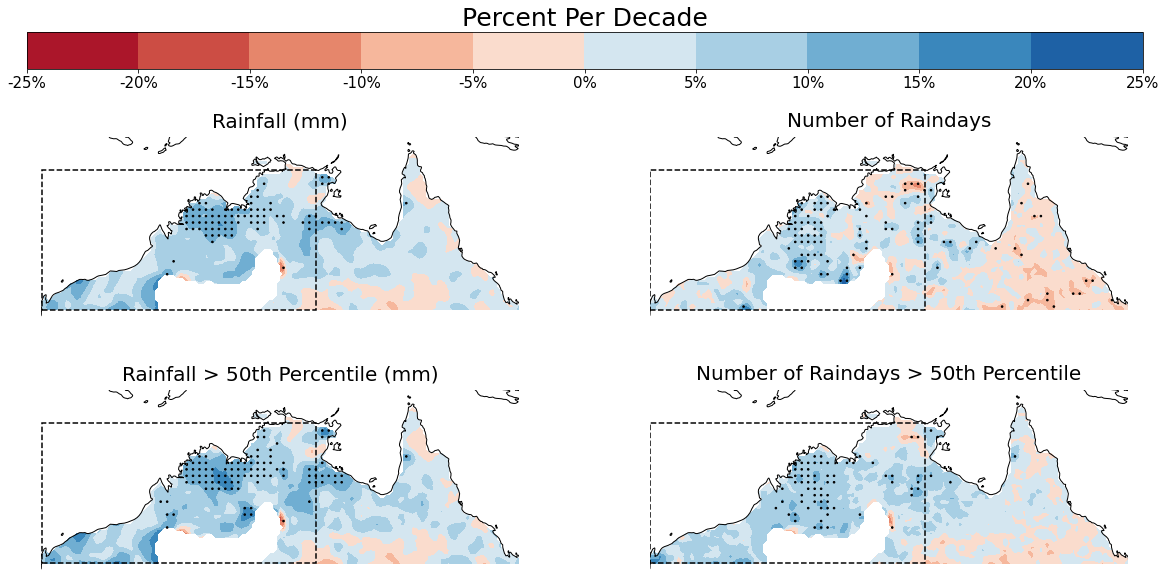

In [47]:
trend_plots(trend_list, sig_list, titles = titles, num_rows = 2, num_cols = 2, vmax = 25,step = 5,
                add_white = 0, extender = 1,
                 suptitle = 'full_trend_1_square',  colorbar_title = 'Percent Per Decade'
#            )
                 ,savedir = savedir)


In [48]:
trend_list_2 = [sum_90_trend_percent, sum_95_trend_percent,
             count_90_trend_percent,count_95_trend_percent]

sig_list_2 = [sum_90_trend_percent_sig, sum_95_trend_percent_sig,
             count_90_trend_percent_sig,count_95_trend_percent_sig]


titles_2 = ['Rainfall > 90th Percentile (mm)','Rainfall > 95th Percentile (mm)',
          'Number of Raindays > 90th Percentile','Number of Raindays > 95th Percentile']

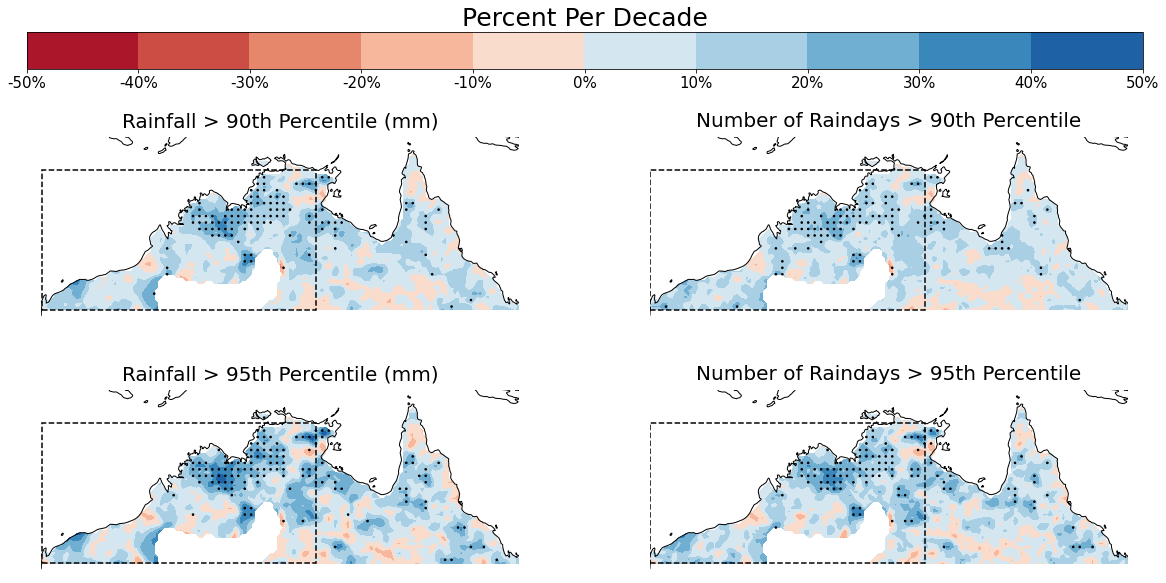

In [50]:
trend_plots(trend_list_2, sig_list_2, titles = titles_2, num_rows = 2, num_cols = 2, vmax = 50,step = 10,
                add_white = 0, extender = 1,  colorbar_title = 'Percent Per Decade',
                 suptitle = 'full_trend_2_square', savedir = savedir)